# Seperating Capacity and Utility 

## Overview 

The capacity and utility features are highly correlated (see below). This can affect overall model performance and feature importances.

To understand the extent of this effect we fit seperate models to capacity and utility features, and compare performance.


- Capacity features: 111 calls offered, Ambulance answered, GP appointments available
- Utility features: 111 calls answered, Ambulance made

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) 
               if '/' in c else c for c in dta.columns]

In [5]:
dta.ccg.unique().shape

(73,)

## Feature correlations 

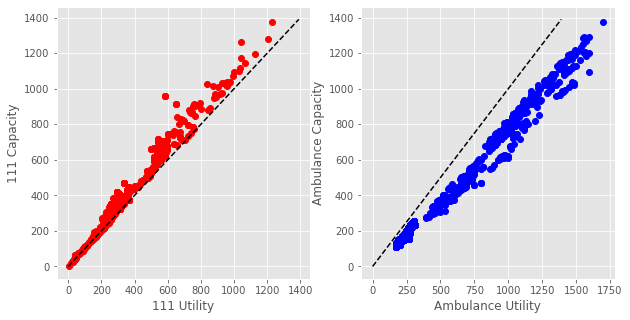

In [6]:
fig,ax_list = plt.subplots(1,2, figsize = (10,5))

xx = np.arange(0,140)*10

ax = ax_list[0]

ax.plot(dta['111_111_answered'].values, dta['111_111_offered'].values, 'ro')
ax.set_xlabel('111 Utility')
ax.set_ylabel('111 Capacity')
ax.plot(xx,xx, 'k--')

ax = ax_list[1]

ax.plot(dta['amb_sys_made'].values, dta['amb_sys_answered'].values, 'bo')
ax.set_xlabel('Ambulance Utility')
ax.set_ylabel('Ambulance Capacity')
ax.plot(xx,xx,'k--')

plt.show()

## Add random feature

In [7]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [8]:
dta.shape

(1465, 14)

## Fitting function 

In [9]:
def fit_model(dta, model, features):
    
    
    y = dta['ae_attendances_attendances']
    X = dta[features]
    
    #cross validate to get errors on performance and coefficients
    cv_model = cross_validate(model, X,y, 
                            cv=RepeatedKFold(n_splits=5, n_repeats=5,
                                             random_state=0),
                            return_estimator=True, 
                              return_train_score=True, n_jobs=2)
    
    clf = model.fit(X, y)

    
    return cv_model

## Utility Model 

In [10]:
features = ['111_111_answered', 'amb_sys_made', 'rand1']

### Linear Regression 

In [11]:
model = LinearRegression()

results = fit_model(dta,model,features)

#### Performance 

In [12]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.088987,0.095958
std,0.019748,0.005173
min,0.048798,0.087471
25%,0.078996,0.092178
50%,0.081917,0.097625
75%,0.098685,0.099210
max,0.127353,0.108243


#### Coefficients 

In [13]:
coefs = pd.DataFrame(
   [model.coef_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,111_111_answered,amb_sys_made,rand1
count,25.000000,25.000000,25.000000
mean,0.326815,-0.152859,33.553221
std,0.019739,0.006087,12.074646
min,0.287791,-0.164263,16.134779
25%,0.314448,-0.157228,22.961364
50%,0.328274,-0.152665,35.276867
75%,0.340023,-0.149892,40.139995
max,0.379046,-0.137929,56.286215


### Random Forest 

In [14]:
model = RandomForestRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [15]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.178456,0.887609
std,0.072714,0.003960
min,0.006091,0.880388
25%,0.135255,0.885376
50%,0.177624,0.888116
75%,0.243312,0.890989
max,0.289105,0.893422


#### Coefficients 

In [16]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,111_111_answered,amb_sys_made,rand1
count,25.000000,25.000000,25.000000
mean,0.207379,0.427613,0.365008
std,0.006546,0.007898,0.010107
min,0.191344,0.412608,0.348829
25%,0.203687,0.422992,0.355853
50%,0.207137,0.427756,0.365537
75%,0.210881,0.432632,0.372431
max,0.222751,0.442107,0.388054


### Gradient Boosted Trees 

In [17]:
model = GradientBoostingRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [18]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.319972,0.496186
std,0.035689,0.009335
min,0.234488,0.481747
25%,0.300244,0.490776
50%,0.328909,0.494394
75%,0.346311,0.499322
max,0.364048,0.516133


#### Coefficients 

In [19]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,111_111_answered,amb_sys_made,rand1
count,25.000000,25.000000,25.000000
mean,0.207306,0.651972,0.140723
std,0.009449,0.011254,0.012983
min,0.190976,0.622205,0.111984
25%,0.198298,0.644356,0.132967
50%,0.209325,0.652536,0.138840
75%,0.215835,0.659531,0.148692
max,0.221563,0.668735,0.162479


### Summary 

Linear regression performs poorly, with an $R^2$ < 0.1

Random Forest overfits to the training data, and the random variable is comparatively important

Gradient boosted trees performs best and does not overfit. The random variable is ranked lowest.

## Capacity Model 

In [20]:
features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

### Linear Regression 

In [21]:
model = LinearRegression()

results = fit_model(dta,model,features)

#### Performance 

In [22]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.104485,0.112303
std,0.021369,0.005553
min,0.064282,0.102830
25%,0.091363,0.108904
50%,0.098609,0.113295
75%,0.118014,0.115696
max,0.142532,0.125342


#### Coefficients 

In [23]:
coefs = pd.DataFrame(
   [model.coef_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.014926,0.406422,-0.131261,28.604220
std,0.004327,0.013028,0.006844,11.985975
min,0.004248,0.372576,-0.143010,10.642999
25%,0.011283,0.399254,-0.134870,16.718126
50%,0.015775,0.408695,-0.132449,30.552794
75%,0.016698,0.414500,-0.127081,36.331556
max,0.022426,0.429938,-0.116957,53.013319


### Random Forest 

In [24]:
model = RandomForestRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [25]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.364431,0.912092
std,0.054716,0.003534
min,0.216132,0.904330
25%,0.352971,0.910534
50%,0.364564,0.911839
75%,0.406865,0.914383
max,0.459843,0.918706


#### Coefficients 

In [26]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.253209,0.240494,0.340623,0.165674
std,0.008955,0.022716,0.022265,0.006641
min,0.235441,0.197214,0.298786,0.154259
25%,0.245963,0.222773,0.327456,0.160431
50%,0.251877,0.241601,0.339803,0.165498
75%,0.262058,0.255507,0.355503,0.169814
max,0.268265,0.286395,0.379297,0.181798


### Gradient Boosted Trees 

In [27]:
model = GradientBoostingRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [28]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.406031,0.579198
std,0.034312,0.010241
min,0.340845,0.563322
25%,0.383876,0.571524
50%,0.402031,0.580027
75%,0.424969,0.586004
max,0.477670,0.596500


#### Coefficients 

In [29]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.167892,0.286557,0.490136,0.055415
std,0.019225,0.061499,0.060725,0.007051
min,0.132097,0.170818,0.407003,0.044458
25%,0.156447,0.230968,0.443732,0.048947
50%,0.166573,0.309052,0.469736,0.056350
75%,0.176401,0.335571,0.538500,0.061889
max,0.201552,0.362549,0.607440,0.067123


### Summary 

Linear regression again performs poorly.

Random Forest overfits to the training data, but the random variable is ranked lowest.

Gradient boosted trees performs best and does not overfit. The random variable is ranked lowest.